# APG-MLE performance

Reconstructing the `cat` state from measurements of the Husimi Q function. The cat state is defined as:

$$|\psi_{\text{cat}} \rangle = \frac{1}{\mathcal N} ( |\alpha \rangle + |-\alpha \rangle \big ) $$

with $\alpha=2$ and normalization $\mathcal N$.

## Husimi Q function measurements

The Husimi Q function can be obtained by calculating the expectation value of measuring the following operator:

$$\mathcal O_i = \frac{1}{\pi}|\beta_i \rangle \langle \beta_i|$$

where $|\beta_i \rangle $ are coherent states written in the Fock basis.


In [49]:
import numpy as np

from qutip import coherent, coherent_dm, expect, Qobj, fidelity, rand_dm
from qutip.wigner import wigner, qfunc

from scipy.io import savemat, loadmat

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%load_ext autoreload
tf.keras.backend.set_floatx('float64') # Set float64 as the default

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


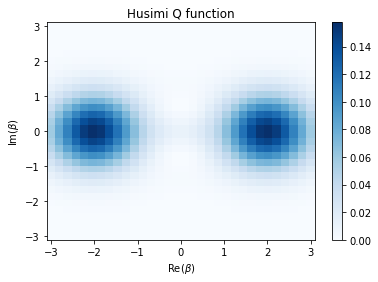

In [43]:
hilbert_size = 32
alpha = 2

psi = coherent(hilbert_size, alpha) + coherent(hilbert_size, -alpha)
psi = psi.unit() # The .unit() function normalizes the state to have unit trace
rho = psi*psi.dag()

grid = 32
xvec = np.linspace(-3, 3, grid)
yvec = np.linspace(-3, 3, grid)

q = qfunc(rho, xvec, yvec, g=2)

cmap = "Blues"
im = plt.pcolor(xvec, yvec, q, vmin=0, vmax=np.max(q), cmap=cmap, shading='auto')
plt.colorbar(im)
plt.xlabel(r"Re($\beta$)")
plt.ylabel(r"Im($\beta$)")
plt.title("Husimi Q function")
plt.show()

# Construct the measurement operators and simulated data (without any noise)

In [44]:
X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()
m_ops = [coherent_dm(hilbert_size, beta) for beta in betas]
data = expect(m_ops, rho)

# APG-MLE

The APG-MLE method implementation in MATLAB provided in https://github.com/qMLE/qMLE requires an input density matrix and a set of measurement operators. Here, we will export the same data to a matlab format and use the APG-MLE method for reconstruction of the density matrix of the state.

In [45]:
ops_numpy = np.array([op.data.toarray() for op in m_ops]) # convert the QuTiP Qobj to numpy arrays
ops = np.transpose(ops_numpy, [1, 2, 0])

mdic = {"measurements": ops}
savemat("data/measurements.mat", mdic)

In [46]:
mdic = {"rho": rho.full()}
savemat("data/rho.mat", mdic)

# Reconstruct using the APG-MLE MATLAB code

In [59]:
fidelities = loadmat("data/fidelities-apg-mle.mat")
fidelities = fidelities['flist1'].ravel()

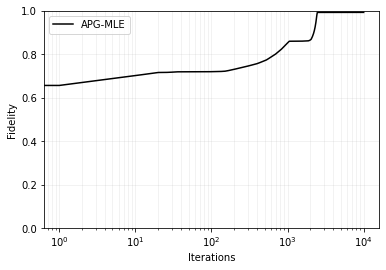

In [60]:
iterations = np.arange(len(fidelities))
plt.plot(iterations, fidelities, color="black", label="APG-MLE")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Fidelity")
plt.ylim(0, 1)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.2)
plt.xscale('log')
plt.show()